<a href="https://colab.research.google.com/github/MrLishu/PHM-Tongji/blob/main/train_drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), 'Mrlishu'))
if os.path.exists('/content'):
    os.chdir('/content')
    CODE_DIR = 'PHM-Tongji'
    if not os.path.exists(CODE_DIR):
        !git clone https://github.com/MrLishu/PHM-Tongji.git $CODE_DIR
    os.chdir(f'./{CODE_DIR}')

    from google.colab import drive
    drive.mount('/content/drive')

Cloning into 'PHM-Tongji'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 158 (delta 5), reused 2 (delta 0), pack-reused 139
Receiving objects: 100% (158/158), 64.98 MiB | 23.18 MiB/s, done.
Resolving deltas: 100% (60/60), done.
Mounted at /content/drive


In [3]:
import numpy as np
from preprocess import cwt

raw_data_directory = r'../drive/PHM-Tongjidata/raw/PHM2010'
processed_data_directory = r'data/processed/PHM2010'

sampling_rate=50000

resample_number=1024
step=1

totalscale=256
wavename='morl'

rs_rate = sampling_rate

c1_resample = np.load(r'data/processed/PHM2010/1d_1C1024_data_c1.npy')[:, :, 3:6].transpose(0, 2, 1)
c1_cwt = cwt(c1_resample, rs_rate, totalscale=totalscale, wavename=wavename, save=True, save_filepath=r'data/processed/PHM2010/cwt_1C1024_c1.npy')
c1_label = np.load(r'data/processed/PHM2010/2d_1C512_data_c1_labels.npy')[:, np.newaxis]

Continuous wavelet transform... (315/315)
Continuous wavelet transform completed.
Data saved at data/processed/PHM2010/cwt_1C1024_c1.npy


In [6]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split

In [7]:
class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [ ]:
train_dataset = MyDataset(c1_cwt, c1_label)
test_dataset = MyDataset(c1_cwt, c1_label)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt


class PHMDataset(Dataset):
    def __init__(self, data_path, dataset_name, train=True, data_num=-1, usecols=('Ax', 'Ay', 'Az'), resample_number=1024, step=1, totalscale=256, wavename='morl'):
        self.data_path = data_path
        self.dataset_name = dataset_name
        self.train = train

        if data_num > 1:
          self.data_num = data_num
        else:
          self.data_num = 315 * len(dataset_name)
        
        self.usecols = usecols
        self.resample_number = resample_number
        self.step = step

        self.signal_length = pd.read_csv(os.path.join(data_path, r'processed/PHM2010/signal_length.csv'))
        self.labelset = {}
        for name in dataset_name:
          self.labelset[name] = pd.read_csv(os.path.join(data_path, rf'raw/PHM2010/{name}_wear.csv'))
        self.columns = ['Fx', 'Fy', 'Fz', 'Ax', 'Ay', 'Az', 'Null']
        sampling_rate = 50000

        fc = pywt.central_frequency(wavename)
        cparam = 2 * fc * totalscale
        self.scales = cparam / np.arange(totalscale, 0, -1)
        self.wavename = wavename
        self.resample_rate = sampling_rate / step
      
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        name = self.dataset_name[idx // 315]
        ci = name[1]
        i = idx % 315
        length = self.signal_length[name][i]

        if self.train:
            start = np.random.randint(length - self.resample_number * self.step)
        else:
            start = (length - self.resample_number * self.step) // 2

        signal = pd.read_csv(os.path.join(self.data_path, rf'raw/PHM2010/{name}/c_{ci}_{i + 1:03d}.csv'), names=self.columns, usecols=self.usecols, skiprows=start, nrows=self.step * self.resample_number)
        resampled = signal.to_numpy().T[:, ::self.step]

        resampled -= resampled.mean(axis=-1)[:, np.newaxis]
        resampled /= resampled.std(axis=-1)[:, np.newaxis]

        cwtmatr, frequencies = pywt.cwt(resampled, self.scales, self.wavename, 1 / self.resample_rate)
        cwtmatr = cwtmatr.transpose(1, 0, 2)

        label = self.labelset[name].iloc[i, 1:].mean()
        return resampled, label

In [ ]:
train_dataset = PHMDataset(r'/content/drive/MyDrive/PHM-Tongji/data', ['c1', 'c4'], False, 315)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

val_dataset = PHMDataset(r'/content/drive/MyDrive/PHM-Tongji/data', ['c1'], False, 30)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=2)

Continuous wavelet transform... (315/315)
Continuous wavelet transform completed.
Data saved at data/processed/PHM2010/cwt_1C1024_c1.npy


In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

train_dataset_1 = MyDataset(c1_resample, c1_label)

In [ ]:
for (i_1, l_1), (i_2, l_2) in zip(train_dataset, train_dataset_1):
  print(np.abs(i_1 - i_2).sum())

108.07299315835866
269.2926869586445
3515.2014836863405
3519.2852309941227
317.39747372526006
2782.995650765767
2980.0919491337904
3153.2198653539494
159.79368045466333
2938.396328579946
237.9676237855087
3117.1289087196974
238.70469670623982
105.43846795300462
3060.1660438698923
242.25188619411455
265.3662947574893
3066.507745390243
3066.459295377078
3020.7486211788973
258.3792825467197
171.28996784060092
125.40271917671637
168.61701013078243
2856.996156802761
298.2340238602273
227.47138507541706
2739.3717252936876
2865.4046923856235
2957.213920205104
74.48674230433019
3231.0142893594057
2652.6253036359053
2947.3082524128613
127.53504778084401
3273.1501912018466
2885.979760217298
3115.822562845551
168.05532534644146
3278.1132578302827
59.21255019514406
2898.574870241179
3071.8583986556846
3171.2072831550595
60.73992080559205
3167.3427114887672
3007.631289851411
283.0743100509851
193.4318476533
72.33959209494537
99.22986699153873
215.3025880957365
319.20289710213945
73.04136597952788
3

In [ ]:
model = models.resnet18(pretrained=False)
# model.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = None

num_epochs = 50

In [ ]:
loss_table = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    running_loss = 0.0

    # Iterate over data.
    for (inputs, labels) in train_dataloader:
        model.train()
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels[:, np.newaxis])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    loss_table.append(running_loss)
    print(f'Running loss: {running_loss:.3f}')
    
    val_loss = 0.0
    error_table = []
    for inputs, labels in val_dataloader:
        model.eval()
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

        error_table += (outputs - labels).flatten().detach().cpu().numpy().tolist()
    
    print(f'Val loss: {val_loss:.3f}')
    print(f'Error mean: {np.abs(error_table).mean():.3f}')
    print(f'Error std: {np.array(error_table).std():.3f}')
    print()


Epoch 0/49
----------
Running loss: 84828.684


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val loss: 11782.189
Error mean: 36.644
Error std: 11.040

Epoch 1/49
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Running loss: 44942.596
Val loss: 3955.890
Error mean: 19.154
Error std: 9.872

Epoch 2/49
----------
Running loss: 17410.451
Val loss: 2248.753
Error mean: 13.784
Error std: 13.090

Epoch 3/49
----------
Running loss: 4581.368
Val loss: 1535.369
Error mean: 11.333
Error std: 13.883

Epoch 4/49
----------
Running loss: 1728.428
Val loss: 1285.803
Error mean: 9.513
Error std: 11.606

Epoch 5/49
----------
Running loss: 1370.042
Val loss: 5304.934
Error mean: 22.930
Error std: 16.779

Epoch 6/49
----------
Running loss: 924.987
Val loss: 1349.559
Error mean: 9.452
Error std: 12.403

Epoch 7/49
----------
Running loss: 1163.517
Val loss: 1462.220
Error mean: 11.379
Error std: 12.094

Epoch 8/49
----------
Running loss: 1206.089
Val loss: 1113.274
Error mean: 9.068
Error std: 11.997

Epoch 9/49
----------
Running loss: 912.130
Val loss: 936.839
Error mean: 8.747
Error std: 10.776

Epoch 10/49
----------
Running loss: 574.575
Val loss: 1211.935
Error mean: 9.709
Error std: 12.448

Epoch 11/

In [ ]:
model.eval()

test_epochs = 10

test_dataset = PHMDataset(r'/content/drive/MyDrive/PHM-Tongji/data', ['c6'])
test_dataloader = DataLoader(test_dataset, batch_size=4, num_workers=2)

label_table = []
predict_table = []

for epoch in range(test_epochs):
  print('Epoch {}/{}'.format(epoch, test_epochs - 1))
  print('-' * 10)

  label_table.append([])
  predict_table.append([])

  for inputs, labels in test_dataloader:
    inputs = inputs.float().to(device)
    labels = labels.float().to(device)

    outputs = model(inputs)

    label_table[-1] += labels.flatten().cpu().numpy().tolist()
    predict_table[-1] += outputs.flatten().cpu().detach().numpy().tolist()

labels = np.array(label_table)
predicted = np.array(predict_table)

Epoch 0/9
----------
Epoch 1/9
----------
Epoch 2/9
----------
Epoch 3/9
----------
Epoch 4/9
----------
Epoch 5/9
----------
Epoch 6/9
----------
Epoch 7/9
----------
Epoch 8/9
----------
Epoch 9/9
----------


In [ ]:
predicted.shape

(10, 315)

In [ ]:
predicted.mean(axis=0)

array([ 70.7268158 , 120.43048782, 123.69195557, 122.329422  ,
       114.03473892, 124.28985748, 124.66302032, 136.39682541,
       127.21336823, 137.35930023, 127.73474197, 117.78426056,
       132.60305328, 131.17757416, 132.07297287, 131.87752533,
       131.68665848, 131.84071808, 134.88467407, 142.42751617,
       127.91921616, 137.17612228, 134.54283829, 140.44174271,
       130.60260468, 138.30974426, 138.89041901, 137.66562347,
       127.73922958, 142.32822113, 136.28320465, 142.02997742,
       136.32817459, 142.09672699, 128.78698959, 143.71660156,
       138.89778824, 135.11018982, 141.46215057, 130.94839478,
       134.54497681, 142.30085907, 143.34087448, 144.77459106,
       139.04930878, 137.96629486, 140.75160446, 144.75423203,
       144.52172928, 145.92323532, 138.93939819, 132.71750259,
       137.68190765, 137.20468445, 140.46499786, 138.259272  ,
       143.83314819, 137.65720444, 142.72806854, 145.83597412,
       133.91816025, 133.96077881, 138.43012619, 137.85

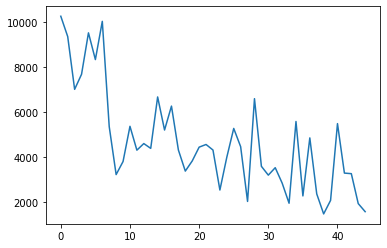

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_table[5:])

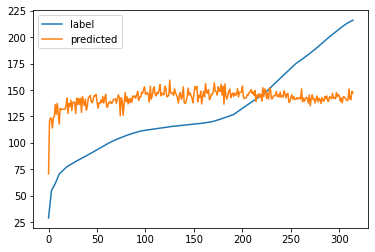

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(labels[0])), labels[0], label='label')
plt.plot(np.arange(len(labels[0])), predicted.mean(axis=0), label='predicted')
plt.legend()

In [ ]:
len = {}
for i in (1, 4, 6):
  len[f'c{i}'] = []
  for j in range(315):
    data = pd.read_csv(rf'/content/drive/MyDrive/PHM-Tongji/data/raw/PHM2010/c{i}/c_{i}_{j + 1:03d}.csv')
    len[f'c{i}'].append(data.shape[0])